In [1]:
# --------------------------------------------
# CONFIGURATION AND DEPENDENCIES
# --------------------------------------------
import os
import cv2
import numpy as np
import torch
import onnxruntime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_score, recall_score, f1_score
)
from torchvision import transforms
from scipy.spatial.distance import cosine
from pathlib import Path
import random

%matplotlib inline


def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)  

# --------------------------------------------
# PATH CONFIGURATION
# --------------------------------------------
BASE_DIR = r"D:\Master's Research\yolo+vos+arcface"
DATASET_DIR = os.path.join(BASE_DIR, "dataset")
MODEL_DIR = os.path.join(BASE_DIR, "models")
OUTPUT_DIR = os.path.join(DATASET_DIR, "cropped")
EMBEDDING_DIR = os.path.join(DATASET_DIR, "embeddings")

# YOLO Paths
YOLO_MODEL_PATH = r"C:\Users\Jaylen LI\yolov7\runs\train\exp4\weights\best.pt"

# Test Data Paths
TEST_IMAGE_DIR = os.path.join(DATASET_DIR, "split", "test", "images")
TEST_MASK_DIR = os.path.join(DATASET_DIR, "split", "test", "masks")
TEST_OUTPUT_DIR = os.path.join(OUTPUT_DIR, "test", "images")

# VOS Integration
VOS_MASK_DIR = os.path.join(DATASET_DIR, "split", "vos_masks")

# Embeddings
TEST_EMBEDDING_DIR = os.path.join(EMBEDDING_DIR, "test")


# --------------------------------------------
# DEVICE SETUP
# --------------------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")


# --------------------------------------------
# LOAD YOLO MODEL
# --------------------------------------------
print("🚀 Loading YOLO model...")
model = torch.hub.load('WongKinYiu/yolov7', 'custom', YOLO_MODEL_PATH, trust_repo=True).to(device)
print("✅ YOLO model loaded successfully!")


# --------------------------------------------
# LOAD ONNX (ArcFace) MODEL
# --------------------------------------------
ONNX_MODEL_PATH = os.path.join(MODEL_DIR, "arcface_r34_ms1mv3.onnx")
session = onnxruntime.InferenceSession(ONNX_MODEL_PATH, providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name
'''
# Transformation Pipeline for ArcFace
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])
'''
# --------------------------------------------
# IMAGE PREPROCESSING
# --------------------------------------------
def preprocess_image(image_path):
    """
    Preprocess image for ONNX model.
    """
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"[Error] Failed to load image: {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = transform(image)
    return image.unsqueeze(0).numpy()



def preprocess_image_with_mask(image_path, mask_path):
    """
    Preprocess image with its corresponding mask for ONNX model.
    """
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path)
    if image is None or mask is None:
        raise FileNotFoundError(f"[Error] Failed to load image or mask: {image_path} / {mask_path}")
    
    masked_image = apply_mask(image, mask)
    masked_image = transform(masked_image)
    return masked_image.unsqueeze(0).numpy()


# --------------------------------------------
# SAVE EMBEDDINGS
# --------------------------------------------

def generate_embeddings(image_path, save_path):
    """
    Generate and save embedding for a pre-masked image.
    """
    tensor = preprocess_image(image_path)  # No mask needed, uses the pre-masked face directly
    embedding = session.run([output_name], {input_name: tensor})[0]
    np.save(save_path, embedding)
    #print(f" Embedded & Saved: {save_path}")
# --------------------------------------------
# 1.9.1 CROPPED IMAGE VISUALIZATION
# --------------------------------------------
import random
import matplotlib.pyplot as plt
import cv2
import os

def visualize_cropped_images(cropped_dir, num_samples=5):
    """
    Visualize a few cropped images from a selected class.
    
    Parameters:
        cropped_dir (str): Path to the directory containing cropped images.
        num_samples (int): Number of sample images to visualize.
    """
    # Ensure directory exists
    if not os.path.exists(cropped_dir):
        print(f"[Error] Directory does not exist: {cropped_dir}")
        return
    
    # Select a random class folder
    classes = [f.path for f in os.scandir(cropped_dir) if f.is_dir()]
    if not classes:
        print("[Error] No class directories found in the cropped images directory.")
        return
    
    sample_class = random.choice(classes)
    sample_images = random.sample(os.listdir(sample_class), min(num_samples, len(os.listdir(sample_class))))
    
    # Plot sample images
    plt.figure(figsize=(15, 10))
    for i, img_file in enumerate(sample_images):
        img_path = os.path.join(sample_class, img_file)
        img = cv2.imread(img_path)
        if img is None:
            print(f"[Warning] Unable to load image: {img_path}")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(f"Class: {os.path.basename(sample_class)}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


# --------------------------------------------
# 1.9.2 t-SNE EMBEDDING VISUALIZATION
# --------------------------------------------
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_embeddings_with_tsne(embeddings, labels):
    """
    Visualize embeddings using t-SNE.
    
    Parameters:
        embeddings (np.array): Array of image embeddings.
        labels (list): Corresponding labels for the embeddings.
    """
    if len(embeddings) == 0:
        print("[Error] No embeddings available for visualization.")
        return
    
    if len(embeddings) != len(labels):
        print("[Error] Mismatch between number of embeddings and labels.")
        return
    
    # Perform t-SNE dimensionality reduction
    reduced_embeddings = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(embeddings)
    
    # Plot t-SNE visualization
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        x=reduced_embeddings[:, 0],
        y=reduced_embeddings[:, 1],
        hue=labels,
        palette='tab20',
        legend='full'
    )
    plt.title('t-SNE Visualization of Embeddings')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()


C:\Anaconda\envs\yolov7_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda
🚀 Loading YOLO model...


Using cache found in C:\Users\Jaylen LI/.cache\torch\hub\WongKinYiu_yolov7_main

                 from  n    params  module                                  arguments                     
  0                -1  1       928  models.common.Conv                      [3, 32, 3, 1]                 
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  2                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]                
  3                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  4                -1  1      8320  models.common.Conv                      [128, 64, 1, 1]               
  5                -2  1      8320  models.common.Conv                      [128, 64, 1, 1]               
  6                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]                
  7                -1  1     36992  models.common.Conv         

Adding autoShape... 
✅ YOLO model loaded successfully!


C:\Anaconda\envs\yolov7_env\lib\site-packages\onnxruntime\capi\onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


In [2]:
import torch.nn as nn
# NEW: ArcMarginProduct Classifier
class ArcMarginProduct(nn.Module):
    def __init__(self, in_features, out_features, s=30.0, m=0.50):
        super(ArcMarginProduct, self).__init__()
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)
        self.s = s
        self.m = m

    def forward(self, input, labels):
        # L2 normalization
        input = F.normalize(input, dim=1)
        weight = F.normalize(self.weight, dim=1)

        cosine = F.linear(input, weight)
        theta = torch.acos(torch.clamp(cosine, -1.0 + 1e-7, 1.0 - 1e-7))
        target_logits = torch.cos(theta + self.m)

        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, labels.view(-1, 1), 1.0)

        output = self.s * (one_hot * target_logits + (1.0 - one_hot) * cosine)
        return output


In [3]:
# --------------------------------------------
#  MASK INTEGRATION WITH CROPPED IMAGES
# --------------------------------------------
import os
import cv2
import numpy as np
from torchvision import transforms

# Paths

#for body
'''
CROPPED_IMAGES_DIR = r"D:\Master's Research\yolo+vos+arcface\dataset_augmented1\masked_bodies"
EMBEDDINGS_DIR = r"D:\Master's Research\yolo+vos+arcface\dataset_augmented1\masked_embeddings_bodies"

MASKS_DIR = r"D:\Master's Research\yolo+vos+arcface\dataset_augmented1\mask_faces"
MASKED_OUTPUT_DIR = r"D:\Master's Research\yolo+vos+arcface\dataset_augmented1\masked_faces"

os.makedirs(MASKED_OUTPUT_DIR, exist_ok=True)
'''
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

In [4]:
#for faces dataset
def process_face_images_with_masks(cropped_images_dir, masks_dir, output_dir):
    """
    Process all cropped face images using corresponding VOS masks.
    """
    for root, _, files in os.walk(cropped_images_dir):
        for file in files:
            if file.endswith('.jpg'):
                image_path = os.path.join(root, file)
                relative_path = os.path.relpath(image_path, cropped_images_dir)

                # Locate the mask
                mask_path = find_matching_mask(image_path, masks_dir)
                if mask_path:
                    output_path = os.path.join(output_dir, relative_path)
                    apply_mask(image_path, mask_path, output_path)
                    

def generate_face_embeddings(masked_faces_dir, embeddings_output_root):
    """
    Generate ArcFace embeddings from pre-masked face/body images and save them
    into a clean mirrored directory structure under embeddings_output_root.
    """
    missing_files = 0
    success_files = 0

    for root, _, files in os.walk(masked_faces_dir):
        for file in files:
            if file.lower().endswith('.jpg'):
                image_path = os.path.join(root, file)

                # Preserve subfolder path relative to the masked_faces_dir
                relative_path = os.path.relpath(image_path, masked_faces_dir)
                npy_path = os.path.join(embeddings_output_root, relative_path).replace('.jpg', '.npy')

                os.makedirs(os.path.dirname(npy_path), exist_ok=True)

                #print(f"[INFO] Processing: {image_path}")
                #print(f"[INFO] Saving embedding to: {npy_path}")

                try:
                    generate_embeddings(image_path, npy_path)
                    success_files += 1
                except Exception as e:
                    print(f"[ERROR] Failed to process {image_path}: {e}")
                    missing_files += 1

    print(f"[INFO]  {success_files} embeddings saved successfully.")
    if missing_files > 0:
        print(f"[WARNING]  {missing_files} images failed to process.")


In [5]:
'''
# Run for both train and test sets
generate_face_embeddings(
    masked_faces_dir=r"D:\Master's Research\yolo+vos+arcface\final_dataset\split_age_folds\fold_4\train\images",
    embeddings_output_root=r"D:\Master's Research\yolo+vos+arcface\final_dataset\split_age_embeddings\fold_4\train\images"
)

generate_face_embeddings(
    masked_faces_dir=r"D:\Master's Research\yolo+vos+arcface\final_dataset\split_age_folds\fold_4\val\images",
    embeddings_output_root=r"D:\Master's Research\yolo+vos+arcface\final_dataset\split_age_embeddings\fold_4\val\images"
)
'''
import shutil
import os

# --- TRAIN EMBEDDINGS ---
train_masked_dir = r"D:\Master's Research\yolo+vos+arcface\final_dataset\split_age_folds\fold_2\train\images"
train_embedding_output = r"D:\Master's Research\yolo+vos+arcface\final_dataset\split_age_embeddings\fold_2\train\images"

if os.path.exists(train_embedding_output):
    shutil.rmtree(train_embedding_output)

generate_face_embeddings(
    masked_faces_dir=train_masked_dir,
    embeddings_output_root=train_embedding_output
)

# --- VALIDATION EMBEDDINGS ---
val_masked_dir = r"D:\Master's Research\yolo+vos+arcface\final_dataset\split_age_folds\fold_2\val\images"
val_embedding_output = r"D:\Master's Research\yolo+vos+arcface\final_dataset\split_age_embeddings\fold_2\val\images"

if os.path.exists(val_embedding_output):
    shutil.rmtree(val_embedding_output)

generate_face_embeddings(
    masked_faces_dir=val_masked_dir,
    embeddings_output_root=val_embedding_output
)



[INFO]  519 embeddings saved successfully.
[INFO]  130 embeddings saved successfully.


In [6]:

generate_face_embeddings(
    masked_faces_dir=r"D:\Master's Research\yolo+vos+arcface\final_dataset\split_age_folds\test\images",
    embeddings_output_root=r"D:\Master's Research\yolo+vos+arcface\final_dataset\split_age_embeddings\test\images"
)


[INFO]  115 embeddings saved successfully.


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image

# Assuming `dataloader` provides images (or you can modify the dataset class to provide images too)
def show_example_image(dataloader):
    # Grab a batch of data
    images, labels = next(iter(dataloader))
    
    # Convert tensor to NumPy array for plotting
    image = images[0].cpu().numpy().transpose(1, 2, 0)  # Assuming the image is in CHW format
    label = labels[0].item()
    
    # Plot the image
    plt.imshow(image)
    plt.title(f"Label: {label}")  # Display the label
    plt.show()


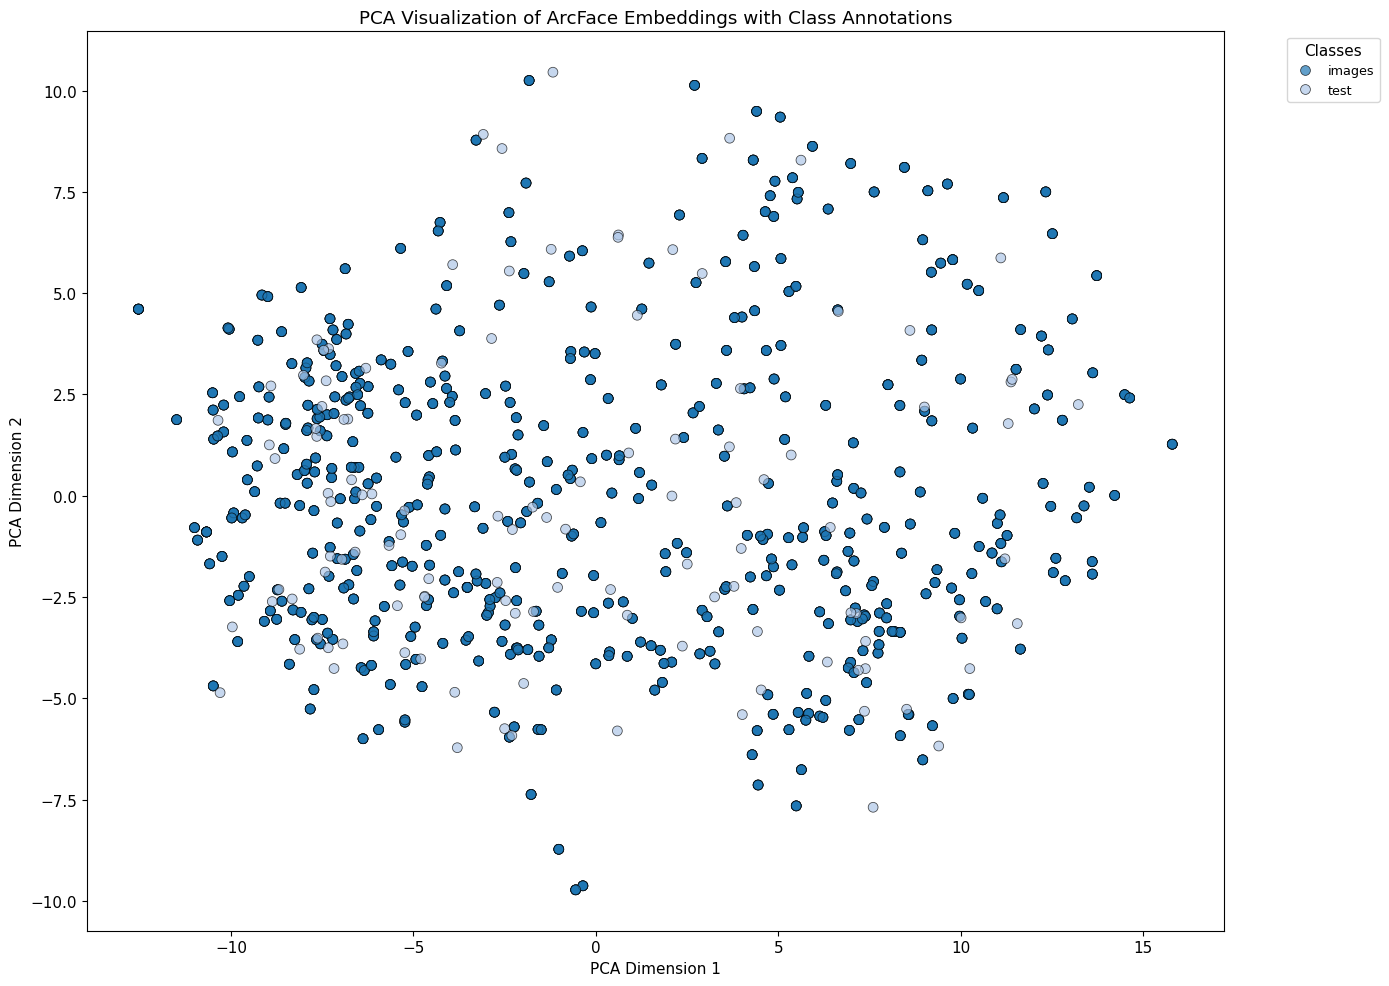

In [8]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
%matplotlib inline

def visualize_embeddings_with_pca(embeddings_dir):
    """
    Visualize embeddings using PCA with meaningful class annotations and improved clarity.
    """
    embeddings = []
    labels = []
    
    # Load embeddings and labels
    for root, _, files in os.walk(embeddings_dir):
        for file in files:
            if file.endswith('.npy'):
                emb = np.load(os.path.join(root, file))
                embeddings.append(emb.flatten())
                labels.append(os.path.basename(os.path.dirname(root)))  # Class folder name
    
    if len(embeddings) == 0:
        print("[Error] No embeddings available for visualization.")
        return
    
    embeddings = np.array(embeddings)
    
    # Reduce dimensions with PCA
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)
    
    # Create DataFrame for plotting
    df = pd.DataFrame({
        'Dimension 1': reduced_embeddings[:, 0],
        'Dimension 2': reduced_embeddings[:, 1],
        'Class': labels
    })
    
    # Plot with seaborn
    plt.figure(figsize=(14, 10))
    sns.scatterplot(
        data=df,
        x='Dimension 1',
        y='Dimension 2',
        hue='Class',
        palette='tab20',
        s=50,  # Size of points
        alpha=0.7,
        edgecolor='k'
    )
    plt.title('PCA Visualization of ArcFace Embeddings with Class Annotations')
    plt.xlabel('PCA Dimension 1')
    plt.ylabel('PCA Dimension 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Classes', fontsize='small')
    plt.tight_layout()
    plt.show()

# Example Usage
EMBEDDINGS_DIR = r"D:\Master's Research\yolo+vos+arcface\dataset_augmented1\masked_embeddings_bodies"
visualize_embeddings_with_pca(EMBEDDINGS_DIR)


In [9]:
from scipy.spatial.distance import cosine
import os
import numpy as np
import random

# --------------------------------------------
# CONFIGURATION
# --------------------------------------------
EMBEDDINGS_DIR = r"D:\Master's Research\yolo+vos+arcface\dataset\embeddings"


# --------------------------------------------
# COSINE SIMILARITY FUNCTION
# --------------------------------------------
def cosine_similarity(embedding1, embedding2):
    """
    Calculate cosine similarity between two embeddings.
    """
    return 1 - cosine(embedding1.flatten(), embedding2.flatten())


# --------------------------------------------
# VALIDATION AND EMBEDDING COLLECTION
# --------------------------------------------
def list_embeddings_by_structure(base_dir):
    """
    List embeddings organized by fold, subset, and class.
    """
    valid_entries = []
    for fold in os.listdir(base_dir):
        fold_path = os.path.join(base_dir, fold)
        if not os.path.isdir(fold_path):
            continue
        
        for subset in ['train', 'val', 'test']:
            subset_path = os.path.join(fold_path, subset, 'images')
            if not os.path.exists(subset_path):
                continue
            
            for class_dir in os.listdir(subset_path):
                class_path = os.path.join(subset_path, class_dir)
                if os.path.isdir(class_path):
                    embedding_files = [f for f in os.listdir(class_path) if f.endswith('.npy')]
                    if embedding_files:
                        valid_entries.append({
                            'fold': fold,
                            'subset': subset,
                            'class': class_dir,
                            'path': class_path,
                            'embeddings': embedding_files
                        })
    return valid_entries


# --------------------------------------------
# COMPARE EMBEDDINGS WITHIN THE SAME CLASS
# --------------------------------------------
valid_entries = list_embeddings_by_structure(EMBEDDINGS_DIR)

# Intra-Class Comparison
valid_intra_class = [entry for entry in valid_entries if len(entry['embeddings']) >= 2]

if valid_intra_class:
    sample_entry = random.choice(valid_intra_class)
    emb1_file, emb2_file = random.sample(sample_entry['embeddings'], 2)
    
    emb1_path = os.path.join(sample_entry['path'], emb1_file)
    emb2_path = os.path.join(sample_entry['path'], emb2_file)
    
    emb1 = np.load(emb1_path)
    emb2 = np.load(emb2_path)
    
    similarity = cosine_similarity(emb1, emb2)
    print(f"🔗 Cosine Similarity (Same Class: {sample_entry['class']}): {similarity:.4f}")


# --------------------------------------------
# COMPARE EMBEDDINGS WITHIN THE SAME CLASS
# --------------------------------------------

valid_intra_class = [entry for entry in valid_entries if len(entry['embeddings']) >= 2]

if valid_intra_class:
    sample_entry = random.choice(valid_intra_class)
    emb1_file, emb2_file = random.sample(sample_entry['embeddings'], 2)
    
    emb1_path = os.path.join(sample_entry['path'], emb1_file)
    emb2_path = os.path.join(sample_entry['path'], emb2_file)
    
    emb1 = np.load(emb1_path)
    emb2 = np.load(emb2_path)
    
    similarity = cosine_similarity(emb1, emb2)
    print(f" Cosine Similarity (Same Class: {sample_entry['class']}): {similarity:.4f}")
    print(f"Embeddings: {emb1_file}, {emb2_file} - Same Class: {sample_entry['class']}")

# --------------------------------------------
# COMPARE EMBEDDINGS ACROSS DIFFERENT CLASSES
# --------------------------------------------

valid_inter_class = [entry for entry in valid_entries if len(entry['embeddings']) > 0]

if len(valid_inter_class) >= 2:
    entry1, entry2 = random.sample(valid_inter_class, 2)
    
    emb1_file = random.choice(entry1['embeddings'])
    emb2_file = random.choice(entry2['embeddings'])
    
    emb1 = np.load(os.path.join(entry1['path'], emb1_file))
    emb2 = np.load(os.path.join(entry2['path'], emb2_file))
    
    similarity = cosine_similarity(emb1, emb2)
    print(f" Cosine Similarity (Different Classes: {entry1['class']} vs {entry2['class']}): {similarity:.4f}")
    print(f"Embeddings: {emb1_file}, {emb2_file} - Different Classes: {entry1['class']} vs {entry2['class']}")


🔗 Cosine Similarity (Same Class: Mojito): 0.3706
 Cosine Similarity (Same Class: Sentinel): 0.5292
Embeddings: frame_0007_5474_devil_0.npy, frame_0006_5474_devil_0.npy - Same Class: Sentinel
 Cosine Similarity (Different Classes: Desoto vs Leyland): 0.2795
Embeddings: frame_0026_5408_devil_0.npy, frame_0004_5420_devil_0.npy - Different Classes: Desoto vs Leyland


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ArcFaceLoss(nn.Module):
    def __init__(self, s=30.0, m=0.50, easy_margin=False):
        """
        ArcFace Loss for deep face recognition.
        Args:
            s (float): Scaling factor (default: 30.0).
            m (float): Angular margin (default: 0.50).
            easy_margin (bool): Whether to use easy margin or not (default: False).
        """
        super(ArcFaceLoss, self).__init__()
        self.s = s  # Scaling factor
        self.m = m  # Angular margin
        self.easy_margin = easy_margin

    def forward(self, embeddings, labels, weight):
        """
        Args:
            embeddings (Tensor): The embeddings generated by the model.
            labels (Tensor): Ground truth labels.
            weight (Tensor): The weight matrix for the classifier (model's last layer).
        """
        # Normalize embeddings and weights
        embeddings = F.normalize(embeddings, p=2, dim=1)
        weight = F.normalize(weight, p=2, dim=1)

        # Calculate cosine similarity between embeddings and weights (dot product)
        cosine_similarity = F.linear(embeddings, weight)  # Dot product

        # Apply margin to the true class
        target_cosine = cosine_similarity[range(len(labels)), labels]
        target_cosine = target_cosine - self.m  # Apply the angular margin

        # Scale the logits
        cosine_similarity *= self.s
        cosine_similarity[range(len(labels)), labels] = target_cosine

        # Compute softmax cross-entropy loss
        loss = F.cross_entropy(cosine_similarity, labels)
        return loss


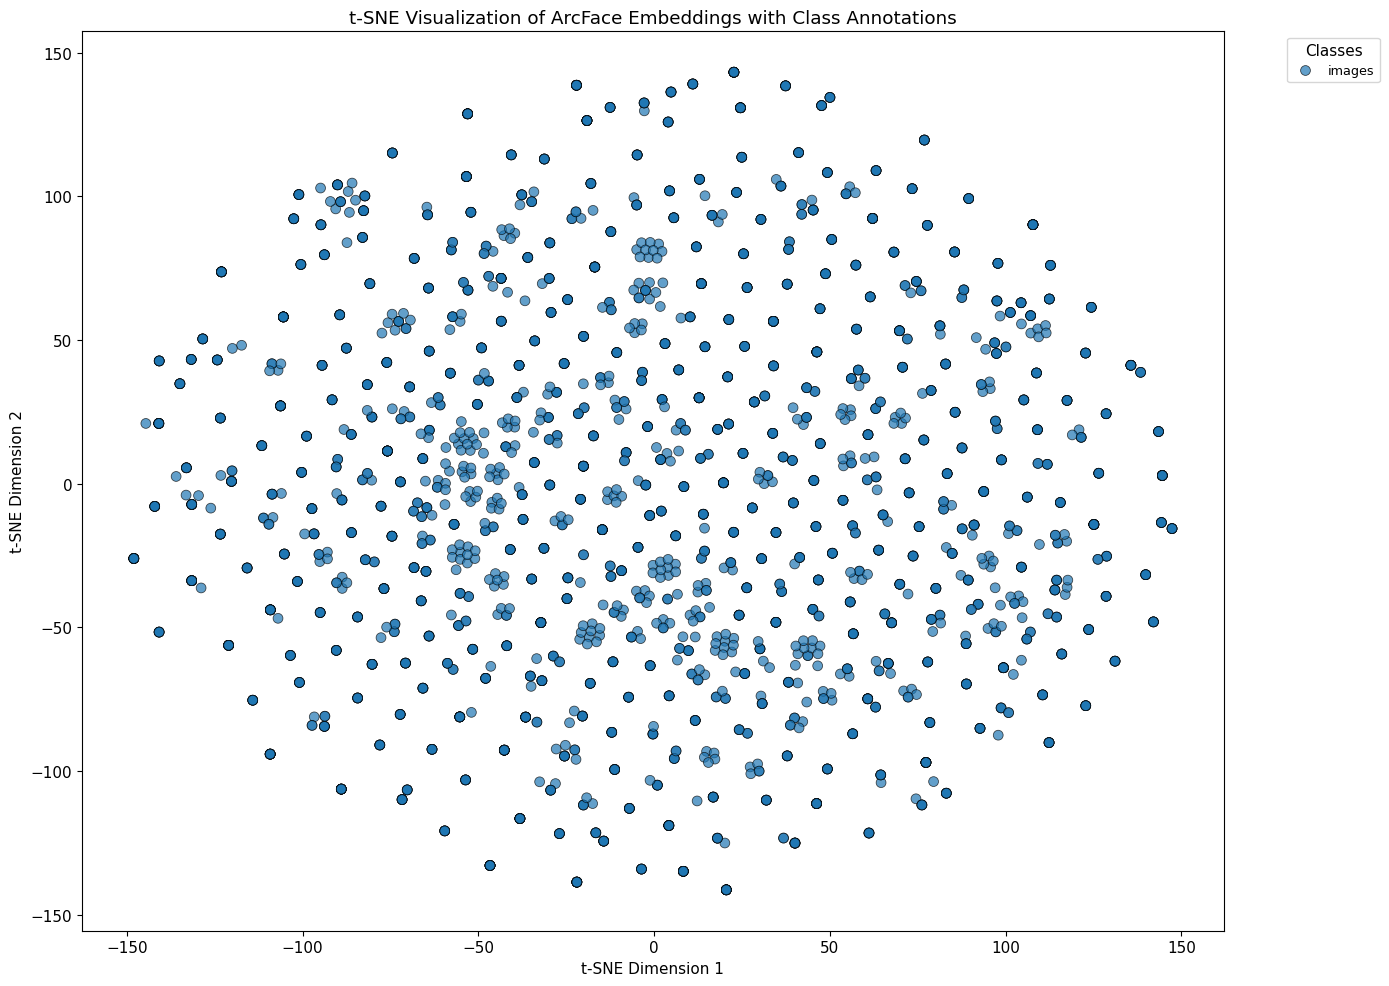

In [11]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
%matplotlib inline

def visualize_embeddings_with_tsne(embeddings_dir):
    """
    Visualize embeddings using t-SNE with meaningful class annotations and improved clarity.
    """
    embeddings = []
    labels = []
    
    # Load embeddings and labels
    for root, _, files in os.walk(embeddings_dir):
        for file in files:
            if file.endswith('.npy'):
                emb = np.load(os.path.join(root, file))
                embeddings.append(emb.flatten())
                labels.append(os.path.basename(os.path.dirname(root)))  # Class folder name
    
    if len(embeddings) == 0:
        print("[Error] No embeddings available for visualization.")
        return
    
    embeddings = np.array(embeddings)
    
    # Ensure sufficient samples for t-SNE perplexity
    perplexity = min(30, len(embeddings) - 1)
    if len(embeddings) <= 1:
        print("[Error] Not enough embeddings for t-SNE visualization.")
        return
    
    # Reduce dimensions with t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings)
    
    # Create DataFrame for plotting
    df = pd.DataFrame({
        'Dimension 1': reduced_embeddings[:, 0],
        'Dimension 2': reduced_embeddings[:, 1],
        'Class': labels
    })
    
    # Plot with seaborn
    plt.figure(figsize=(14, 10))
    sns.scatterplot(
        data=df,
        x='Dimension 1',
        y='Dimension 2',
        hue='Class',
        palette='tab20',
        s=50,  # Size of points
        alpha=0.7,
        edgecolor='k'
    )
    plt.title('t-SNE Visualization of ArcFace Embeddings with Class Annotations')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Classes', fontsize='small')
    plt.tight_layout()
    plt.show()

# Example Usage
EMBEDDINGS_DIR = r"D:\Master's Research\yolo+vos+arcface\dataset\embeddings"
visualize_embeddings_with_tsne(EMBEDDINGS_DIR)


[Info] Loaded 519 embeddings.
[Info] Label distribution: {0: 324, 1: 165, 2: 30}
[Info] Loaded 130 embeddings.
[Info] Label distribution: {0: 81, 1: 41, 2: 8}
Epoch [1/300], Train Loss: 1.0875, Val Loss: 1.0719, Train Acc: 0.3926, Val Acc: 0.5156
Epoch [2/300], Train Loss: 1.0654, Val Loss: 1.0674, Train Acc: 0.5215, Val Acc: 0.4688
Epoch [3/300], Train Loss: 1.0474, Val Loss: 1.0544, Train Acc: 0.5605, Val Acc: 0.4688
Epoch [4/300], Train Loss: 1.0296, Val Loss: 1.0406, Train Acc: 0.5742, Val Acc: 0.4844
Epoch [5/300], Train Loss: 1.0104, Val Loss: 1.0254, Train Acc: 0.6211, Val Acc: 0.5312
Epoch [6/300], Train Loss: 0.9921, Val Loss: 1.0045, Train Acc: 0.6211, Val Acc: 0.5547
Epoch [7/300], Train Loss: 0.9762, Val Loss: 0.9898, Train Acc: 0.6406, Val Acc: 0.5781
Epoch [8/300], Train Loss: 0.9568, Val Loss: 0.9768, Train Acc: 0.6426, Val Acc: 0.6016
Epoch [9/300], Train Loss: 0.9438, Val Loss: 0.9589, Train Acc: 0.6406, Val Acc: 0.6094
Epoch [10/300], Train Loss: 0.9311, Val Loss: 0.9

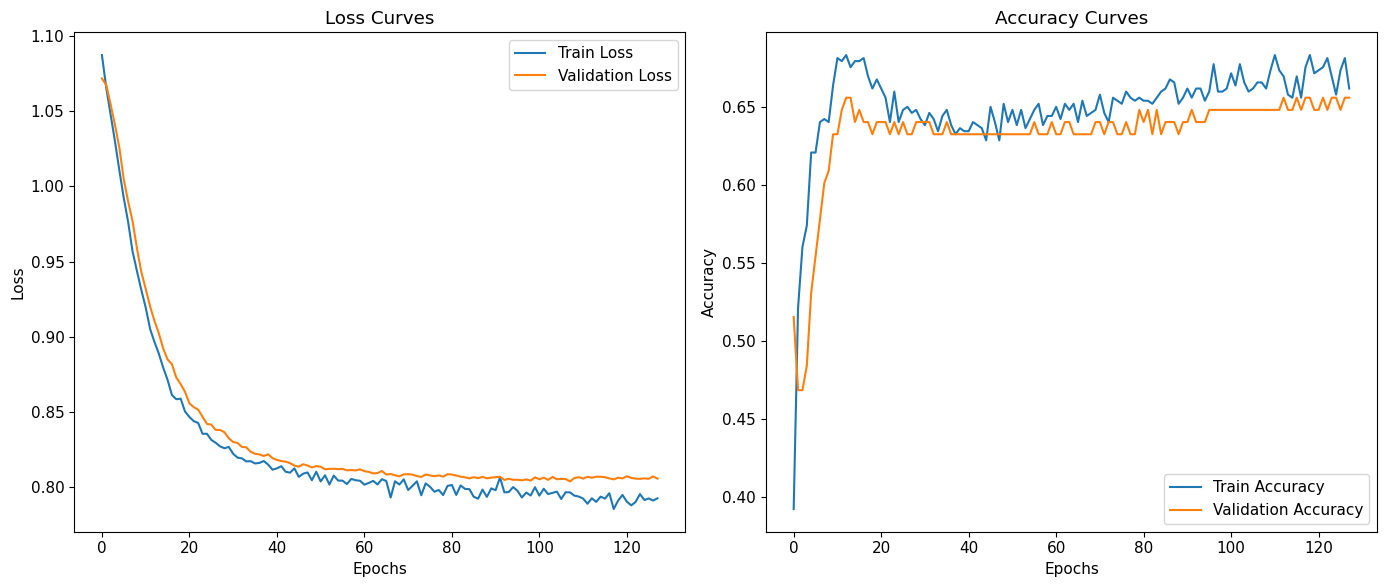

In [12]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# --------------------------------------------
# CONFIGURATION
# --------------------------------------------

TRAIN_EMBEDDING_DIR = r"D:\Master's Research\yolo+vos+arcface\final_dataset\split_age_embeddings\fold_2\train\images"
VAL_EMBEDDING_DIR = r"D:\Master's Research\yolo+vos+arcface\final_dataset\split_age_embeddings\fold_2\val\images"
TEST_EMBEDDING_DIR = r"D:\Master's Research\yolo+vos+arcface\final_dataset\split_age_embeddings\test\images"

MODEL_SAVE_PATH = r"D:\\Master's Research\\yolo+vos+arcface\\models\\arcface_age_model_fold1.pth"

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --------------------------------------------
# DATASET CLASS
# --------------------------------------------
class EmbeddingDataset(Dataset):
    def __init__(self, embedding_dir, label_encoder):
        self.embeddings = []
        self.labels = []

        for root, dirs, files in os.walk(embedding_dir):
            for file in files:
                if file.endswith('.npy'):
                    emb_path = os.path.join(root, file)
                    emb = np.load(emb_path)
                    self.embeddings.append(emb.flatten())

                    # FIX: extract age class from grandparent directory
                    class_label = os.path.basename(os.path.dirname(os.path.dirname(emb_path)))
                    self.labels.append(class_label)

        self.embeddings = torch.tensor(np.array(self.embeddings), dtype=torch.float32)
        self.labels = torch.tensor(label_encoder.transform(self.labels), dtype=torch.long)

        print(f"[Info] Loaded {len(self.embeddings)} embeddings.")
        print(f"[Info] Label distribution: {dict(zip(*np.unique(self.labels.numpy(), return_counts=True)))}")

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

# --------------------------------------------
# MODEL DEFINITION
# --------------------------------------------
class ArcFaceModel(nn.Module):
    def __init__(self, embedding_size):
        super(ArcFaceModel, self).__init__()
        self.bn = nn.BatchNorm1d(embedding_size)

    def forward(self, x):
        x = self.bn(x)
        x = F.normalize(x, p=2, dim=1)
        return x

class ArcMarginProduct(nn.Module):
    def __init__(self, embedding_size, num_classes):
        super(ArcMarginProduct, self).__init__()
        self.weight = nn.Parameter(torch.FloatTensor(num_classes, embedding_size))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, embeddings, labels):
        cosine = F.linear(F.normalize(embeddings), F.normalize(self.weight))
        return cosine

# --------------------------------------------
# TRAINING FUNCTION
# --------------------------------------------
def train_model(model, arc_margin, train_loader, val_loader, criterion, optimizer, num_epochs=300, patience=20):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_loss = float('inf')
    patience_counter = 0

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, min_lr=0.0001)

    for epoch in range(num_epochs):
        model.train()
        arc_margin.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for embeddings, labels in train_loader:
            embeddings, labels = embeddings.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            features = model(embeddings)
            logits = arc_margin(features, labels)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(logits, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = correct_train / total_train
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        model.eval()
        arc_margin.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for embeddings, labels in val_loader:
                embeddings, labels = embeddings.to(DEVICE), labels.to(DEVICE)
                features = model(embeddings)
                logits = arc_margin(features, labels)
                loss = criterion(logits, labels)
                val_loss += loss.item()
                _, predicted = torch.max(logits, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_accuracy = correct_val / total_val
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_accuracy)

        scheduler.step(val_loss / len(val_loader))

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, "
              f"Val Loss: {val_losses[-1]:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save({'model_state_dict': model.state_dict(),
                        'arc_margin_state_dict': arc_margin.state_dict()}, MODEL_SAVE_PATH)
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    return train_losses, val_losses, train_accuracies, val_accuracies

# --------------------------------------------
# MAIN EXECUTION
# --------------------------------------------
label_encoder = LabelEncoder()
label_encoder.fit(['1', '2', '3'])

train_dataset = EmbeddingDataset(TRAIN_EMBEDDING_DIR, label_encoder)
val_dataset = EmbeddingDataset(VAL_EMBEDDING_DIR, label_encoder)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False, drop_last=True)

embedding_size = 512
num_classes = len(label_encoder.classes_)

model = ArcFaceModel(embedding_size=embedding_size).to(DEVICE)
arc_margin = ArcMarginProduct(embedding_size, num_classes).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(list(model.parameters()) + list(arc_margin.parameters()), lr=0.001)

train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, arc_margin, train_loader, val_loader, criterion, optimizer
)

MODEL_SAVE_PATH = r"D:\Master's Research\unified_dataset\models\arcface_age.pth"
os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)
torch.save(model.state_dict(), MODEL_SAVE_PATH)

print("Training complete and model saved.")

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [13]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)

def evaluate_model(model, arc_margin, dataloader, label_encoder, output_prefix="eval"):
    """
    Evaluate the ArcFace model and ArcMargin classifier on a given dataset.
    Saves classification report and confusion matrix to disk.
    """
    model.eval()
    arc_margin.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for embeddings, labels in dataloader:
            embeddings, labels = embeddings.to(DEVICE), labels.to(DEVICE)
            features = model(embeddings)
            logits = arc_margin(features, labels)
            _, predicted = torch.max(logits, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Decode predictions and labels
    y_true = label_encoder.inverse_transform(all_labels)
    y_pred = label_encoder.inverse_transform(all_preds)

    # Compute scores
    val_accuracy = accuracy_score(y_true, y_pred)
    val_precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    val_recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    val_f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    print(f"\n {output_prefix.upper()} SET PERFORMANCE")
    print(f"Accuracy:  {val_accuracy:.4f}")
    print(f"Precision: {val_precision:.4f}")
    print(f"Recall:    {val_recall:.4f}")
    print(f"F1-Score:  {val_f1:.4f}\n")

    # === Save paths ===
    result_dir = os.path.join(r"D:\Master's Research\yolo+vos+arcface\results\age", output_prefix)
    os.makedirs(result_dir, exist_ok=True)

    # === Classification Report (.txt + .csv)
    report_txt_path = os.path.join(result_dir, "classification_report.txt")
    report_csv_path = os.path.join(result_dir, "classification_report.csv")

    report = classification_report(y_true, y_pred, zero_division=0)
    print(report)

    with open(report_txt_path, "w") as f:
        f.write(report)

    report_dict = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    pd.DataFrame(report_dict).transpose().to_csv(report_csv_path)

    # === Confusion Matrix (.csv + .png)
    cm = confusion_matrix(y_true, y_pred, labels=label_encoder.classes_)
    cm_normalized = np.nan_to_num(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])

    cm_csv_path = os.path.join(result_dir, "confusion_matrix.csv")
    cm_png_path = os.path.join(result_dir, "confusion_matrix.png")

    pd.DataFrame(cm_normalized, index=label_encoder.classes_, columns=label_encoder.classes_).to_csv(cm_csv_path)

    # Plot and save confusion matrix heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f'Normalized Confusion Matrix ({output_prefix})')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(cm_png_path, dpi=300)
    plt.close()

    
# === VALIDATION EVALUATION ===
print("\nEvaluating on Validation Set...")
evaluate_model(model, arc_margin, val_loader, label_encoder, output_prefix="val_age")

# === TEST EVALUATION ===
print("\nEvaluating on Test Set...")
test_dataset = EmbeddingDataset(TEST_EMBEDDING_DIR, label_encoder)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
evaluate_model(model, arc_margin, test_loader, label_encoder, output_prefix="test_age")



Evaluating on Validation Set...

 VAL_AGE SET PERFORMANCE
Accuracy:  0.6562
Precision: 0.7304
Recall:    0.6562
F1-Score:  0.5413

              precision    recall  f1-score   support

           1       0.65      1.00      0.79        81
           2       1.00      0.07      0.14        41
           3       0.00      0.00      0.00         6

    accuracy                           0.66       128
   macro avg       0.55      0.36      0.31       128
weighted avg       0.73      0.66      0.54       128


Evaluating on Test Set...
[Info] Loaded 115 embeddings.
[Info] Label distribution: {0: 70, 1: 38, 2: 7}

 TEST_AGE SET PERFORMANCE
Accuracy:  0.6783
Precision: 0.7286
Recall:    0.6783
F1-Score:  0.5964

              precision    recall  f1-score   support

           1       0.65      1.00      0.79        70
           2       1.00      0.21      0.35        38
           3       0.00      0.00      0.00         7

    accuracy                           0.68       115
   macro a